In [32]:
import sys; sys.path.append('..')

import torch
import numpy as np
import os
from glob import glob

from os.path import join as pjoin
import torch.nn.functional as F
import matplotlib.pyplot as plt
from src.visualize import visualize_fc_weights
from natsort import natsorted
# from src.utils import standardize

In [45]:
dict_type = "ortho"
patch_height = 12
patch_width = 12
m = 40
seed = 2

dict_loc = f"{dict_type}_{patch_width}x{patch_height}_m={m}_seed={seed}"

sigma = 0.1
width = 1
k = 1
bs = 1
lr = 1

n = 50000
noise = 0.0
act = "ReLU"
tied = True
alg = "sgd"

data_dir = f"{dict_loc}_k={k}_n={n}_noise={noise}"
arch_dir = f"fc_width={width}_act={act}_tied={tied}"
exp_prefix = f"fc_{alg}_lr={lr}_bs={bs}_sigma={sigma}"


In [46]:
def get_exp_dir(epoch, step):
    return f"{exp_prefix}_epoch={epoch}_step={step}"

def get_weights_loc(epoch, step):
    exp_dir = get_exp_dir(epoch, step)
    weights_loc = pjoin("../saved_weights", data_dir, arch_dir, exp_dir)
    return weights_loc

def load_all_weights():
    dir = pjoin("../saved_weights", data_dir, arch_dir)
    locs = natsorted(glob("{p}*".format(p=pjoin(dir, exp_prefix))))
    weights = []
    for loc in locs:
        W = torch.load(loc, map_location=torch.device("cpu"))['W']
        weights.append(W.squeeze())
    return weights

def get_dict_loc():
    return pjoin("../dictionaries", dict_loc)

def corr_mat(X, Y):
    return F.normalize(X) @ F.normalize(Y).T

In [47]:
dictionary = torch.load(get_dict_loc())
weights = load_all_weights()

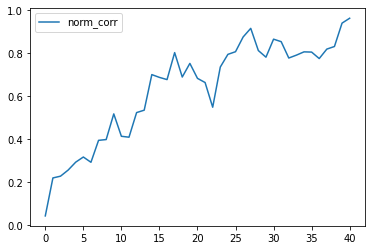

0.044529277831315994


In [48]:
last_corr = corr_mat(dictionary, weights[-1].unsqueeze(0))
winner_idx = torch.argmax(last_corr).item()
winner = dictionary[winner_idx]
corr = [torch.dot(W / torch.linalg.norm(W), winner).item() for W in weights]
plt.plot(np.arange(len(corr)), corr, label="norm_corr")
plt.legend()
plt.show()
print(corr[0])


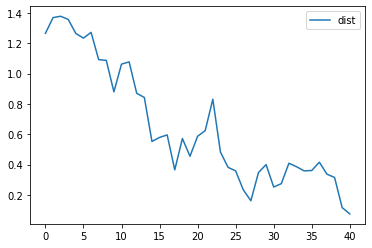

In [49]:
dist = np.array([torch.linalg.norm(W - winner).item() for W in weights])
plt.plot(np.arange(len(dist)), dist * dist, label="dist")
plt.legend()
plt.show()

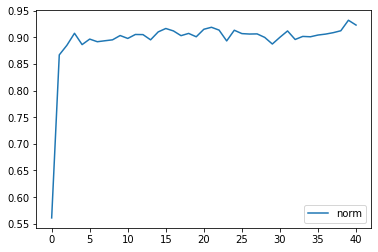

In [50]:
norm = [torch.linalg.norm(W).item() for W in weights]
plt.plot(np.arange(len(norm)), norm, label="norm")
plt.legend()
plt.show()

In [51]:
W0 = torch.load(get_weights_loc(0, 0), map_location=torch.device("cpu"))['W']
W1 = torch.load(get_weights_loc(3, 199999), map_location=torch.device("cpu"))['W']
dictionary = torch.load(get_dict_loc())

corr0 = corr_mat(dictionary, W0).squeeze()
corr1 = corr_mat(dictionary, W1).squeeze()


In [52]:
amax0 = torch.argmax(corr0)
amax1 = torch.argmax(corr1)
print(amax0, amax1)
print(corr0[amax0], corr0[amax1])


tensor(9) tensor(30)
tensor(0.1509) tensor(0.0445)


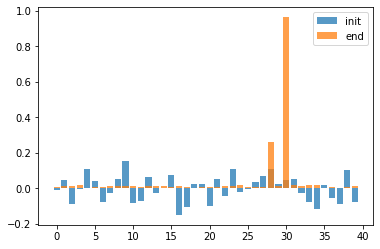

In [53]:
plt.bar(np.arange(m), corr0.numpy(), alpha=0.75, label="init")
plt.bar(np.arange(m), corr1.numpy(), alpha=0.75, label="end")
plt.legend()
plt.show()